In [0]:
# import libraries
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank, avg, mean
from pyspark.sql.functions import min
from pyspark.sql.functions import col, max
from pyspark.sql.functions import format_string
from pyspark.sql.functions import substring
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import concat
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import lit
from pyspark.sql.functions import to_utc_timestamp
from pyspark.sql.functions import expr
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import instr
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.ml.linalg import DenseVector, SparseVector, Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer,OneHotEncoder
from pyspark.ml.classification import MultilayerPerceptronClassifier


from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

import seaborn as sns

In [0]:
#Initializes blob storage credentials/location
blob_container = "w261-sec4-group2" # The name of your container created in https://portal.azure.com
storage_account = "kdevery" # The name of your Storage account created in https://portal.azure.com
secret_scope = "sec4-group2" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

#Points to SAS token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
display(dbutils.fs.ls(f"{blob_url}"))

path,name,size,modificationTime
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/MLPC_predictions_df/,MLPC_predictions_df/,0,1670111625000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/MLPC_predictions_df_no_undersampling/,MLPC_predictions_df_no_undersampling/,0,1670192176000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_data/,feature_engineered_data/,0,1668924639000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_data_test/,feature_engineered_data_test/,0,1668924670000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_train_data/,feature_engineered_train_data/,0,1668559613000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data/,merged_cleaned_data/,0,1669494945000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data_test/,merged_cleaned_data_test/,0,1669495012000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data_train/,merged_cleaned_data_train/,0,1669495000000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_data/,merged_data/,0,1669494746000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/number_flights_and_delay_rate/,number_flights_and_delay_rate/,0,1669961275000


In [0]:
#Read processed folds from the blob
d_processed = {}

d_processed['df1'] = spark.read.parquet(f"{blob_url}/processed_fold_1")
d_processed['df2'] = spark.read.parquet(f"{blob_url}/processed_fold_2")
d_processed['df3'] = spark.read.parquet(f"{blob_url}/processed_fold_3")
d_processed['df4'] = spark.read.parquet(f"{blob_url}/processed_fold_4")
d_processed['df5'] = spark.read.parquet(f"{blob_url}/processed_fold_5")

### Model Building

In [0]:
%run "/Shared/w261_Section4_Group2/Phase 3/custom_cv_module"

#### Gradient Boosting Classifier - Cross Validation

In [0]:
gbt_model = GBTClassifier(labelCol="label", featuresCol="scaled_feature_vector")

grid = ParamGridBuilder()\
            .addGrid(gbt_model.maxDepth, [5,10])\
            .addGrid(gbt_model.minInfoGain,[0.0,0.2,0.4])\
            .addGrid(gbt_model.maxBins, [32,64])\
            .build()
            
# Example using F0.5 score for evaluator
evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=0.5, metricLabel=1)

In [0]:
# run cross validation & return the crossvalidation F0.5 score for 'test' set
cv = CustomCrossValidator(estimator=gbt_model, estimatorParamMaps=grid, evaluator=evaluator,splitWord =('train','val'), cvCol = 'cv',parallelism=10)

In [0]:
cvModel = cv.fit(d_processed)

fold 1 start...
fold 1 end
fold 2 start...
fold 2 end
fold 3 start...
fold 3 end
fold 4 start...
fold 4 end
fold 5 start...
fold 5 end
Best Model:  {Param(parent='GBTClassifier_2a68eca312bf', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='GBTClassifier_2a68eca312bf', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='GBTClassifier_2a68eca312bf', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 64} Detailed Score [0.6162719704113895, 0.618134873814376, 0.6168874850995011, 0.6080195374406504, 0.5586906757282664] Avg Score 0.6036009084988366


In [0]:
# make predictions
predictions = cvModel.transform(d_processed['df1'])

display(predictions.groupby('label', 'prediction').count())

label,prediction,count
1.0,1.0,490396
0.0,1.0,198744
1.0,0.0,780572
0.0,0.0,5603618


In [0]:
fbeta = cvModel.avgMetrics[0]
print(f"Gradient Boosting F0.5 Score: {fbeta}")

Gradient Boosting F0.5 Score: 0.6034083183573311


#### Full Train and Test

In [0]:
# Read in processed training and test data

processed_train_df = spark.read.parquet(f"{blob_url}/processed_train")
processed_test_df = spark.read.parquet(f"{blob_url}/processed_test")

In [0]:
final_gbt_model = GBTClassifier(labelCol="label", featuresCol="scaled_feature_vector",maxDepth=5, minInfoGain=0, maxBins=64)
evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=0.5, metricLabel=1)
gbtModel = final_gbt_model.fit(processed_train_df)

In [0]:
feature_importance_df = pd.DataFrame(gbtModel.featureImportances.toArray())
feature_importance_df.columns = ['Importance_Score']

In [0]:
feature_cols= ['MONTH','DAY_OF_MONTH','DAY_OF_WEEK','DISTANCE','HourlyWindSpeed','Rain','Blowing','Snow','Thunder','CloudySkyCondition','carrier_vec','holiday_period','mean_carrier_delay','Pagerank_Score','PREV_FLIGHT_DELAYED','origin_percent_delayed','dest_percent_delayed','ORIGIN_Prophet_trend','ORIGIN_Prophet_pred','DEST_Prophet_trend','DEST_Prophet_pred']

len(feature_cols)

Out[18]: 21

Out[26]: Text(0.5, 1.0, 'Feature Importance')

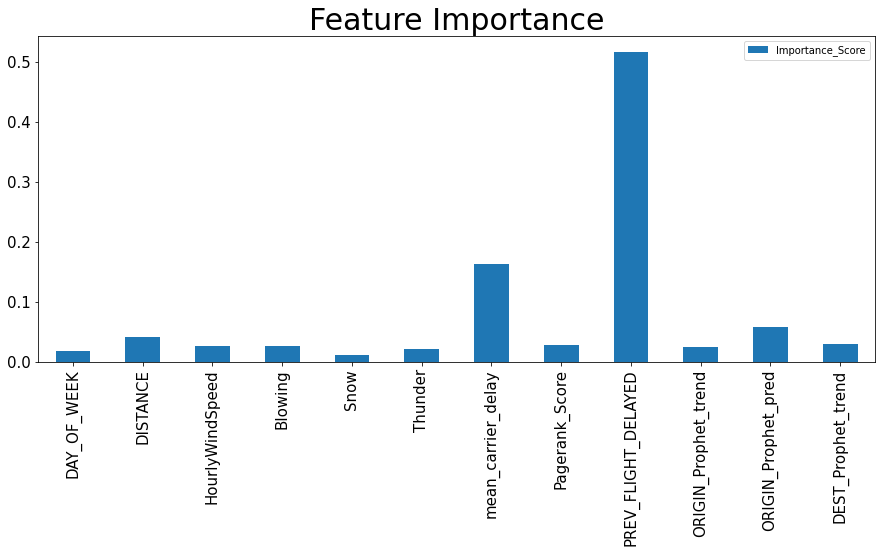

In [0]:
plot_df = feature_importance_df[feature_importance_df['Importance_Score'] > 0.01]
plot_df.index = ['DAY_OF_WEEK', 'DISTANCE', 'HourlyWindSpeed', 'Blowing', 'Snow', 'Thunder', 'mean_carrier_delay', 'Pagerank_Score', 'PREV_FLIGHT_DELAYED', 'ORIGIN_Prophet_trend', 'ORIGIN_Prophet_pred', 'DEST_Prophet_trend']

plot = plot_df.plot(kind='bar',figsize = (15,6),title='Feature Importance',fontsize=15)
plot.axes.set_title("Feature Importance",fontsize=30)

In [0]:
predictions = gbtModel.transform(processed_test_df)

In [0]:
display(predictions.groupby('label', 'prediction').count())

label,prediction,count
1.0,1.0,341825
0.0,1.0,130365
1.0,0.0,676878
0.0,0.0,4710238


In [0]:
evaluator.evaluate(predictions)

Out[8]: 0.5880239726910806

In [0]:
display(predictions)

label,scaled_feature_vector,index,rawPrediction,probability,prediction
0.0,"Map(vectorType -> sparse, length -> 39, indices -> List(0, 1, 2, 3, 4, 9, 22, 30, 31, 33, 35, 36, 37, 38), values -> List(0.6062867010278674, 0.4552178936348829, 1.9962981366261658, 1.1771165614071244, 1.1807240188784864, 2.001448286999518, 4.804541102597839, 0.5290014255667469, 2.5358333967474525, 0.3529775526800816, 2.2518971367325515, 0.2623600525700863, 2.453487744696793, 0.4321511055947388))",0,"Map(vectorType -> dense, length -> 2, values -> List(1.2863825675902658, -1.2863825675902658))","Map(vectorType -> dense, length -> 2, values -> List(0.9290880887467422, 0.0709119112532578))",0.0
0.0,"Map(vectorType -> sparse, length -> 39, indices -> List(0, 1, 2, 3, 4, 9, 21, 30, 31, 33, 35, 36, 37, 38), values -> List(0.6062867010278674, 0.4552178936348829, 1.9962981366261658, 0.8181980723075531, 1.518073738558054, 2.001448286999518, 5.254269120180973, 0.34977829198919363, 0.9689112552858259, 0.433041426600483, 2.3371183222456193, 0.27964920300085777, 2.453487744696793, 0.4321511055947388))",1,"Map(vectorType -> dense, length -> 2, values -> List(1.3245883488616268, -1.3245883488616268))","Map(vectorType -> dense, length -> 2, values -> List(0.9339602285819425, 0.0660397714180575))",0.0
0.0,"Map(vectorType -> sparse, length -> 39, indices -> List(0, 1, 2, 3, 4, 9, 21, 30, 31, 33, 35, 36, 37, 38), values -> List(0.6062867010278674, 0.4552178936348829, 1.9962981366261658, 0.8181980723075531, 1.1807240188784864, 2.001448286999518, 5.254269120180973, 0.4050167164495406, 0.9689112552858259, 0.433041426600483, 2.3371183222456193, 0.27964920300085777, 2.453487744696793, 0.4321511055947388))",2,"Map(vectorType -> dense, length -> 2, values -> List(1.3172303719234788, -1.3172303719234788))","Map(vectorType -> dense, length -> 2, values -> List(0.9330467532311058, 0.06695324676889425))",0.0
0.0,"Map(vectorType -> sparse, length -> 39, indices -> List(0, 1, 2, 3, 9, 21, 30, 31, 33, 35, 36, 37, 38), values -> List(0.6062867010278674, 0.4552178936348829, 1.9962981366261658, 0.8181980723075531, 2.001448286999518, 5.254269120180973, 0.34688490538266537, 0.9689112552858259, 0.433041426600483, 2.3371183222456193, 0.27964920300085777, 2.453487744696793, 0.4321511055947388))",3,"Map(vectorType -> dense, length -> 2, values -> List(1.3245883488616268, -1.3245883488616268))","Map(vectorType -> dense, length -> 2, values -> List(0.9339602285819425, 0.0660397714180575))",0.0
0.0,"Map(vectorType -> sparse, length -> 39, indices -> List(0, 1, 2, 3, 4, 9, 22, 30, 31, 33, 35, 36, 37, 38), values -> List(0.6062867010278674, 0.4552178936348829, 1.9962981366261658, 0.722940084679231, 2.361448037756973, 2.001448286999518, 4.804541102597839, 0.38154845811321203, 0.7047198828462189, 0.5403663049134857, 1.8916360906620093, 0.4360534659923761, 2.453487744696793, 0.4321511055947388))",4,"Map(vectorType -> dense, length -> 2, values -> List(1.3172303719234788, -1.3172303719234788))","Map(vectorType -> dense, length -> 2, values -> List(0.9330467532311058, 0.06695324676889425))",0.0
0.0,"Map(vectorType -> sparse, length -> 39, indices -> List(0, 1, 2, 3, 4, 9, 22, 30, 31, 33, 35, 36, 37, 38), values -> List(0.6062867010278674, 0.4552178936348829, 1.9962981366261658, 0.722940084679231, 0.8433742991989189, 2.001448286999518, 4.804541102597839, 0.3154302374467945, 0.7047198828462189, 0.5403663049134857, 1.8916360906620093, 0.4360534659923761, 2.453487744696793, 0.4321511055947388))",5,"Map(vectorType -> dense, length -> 2, values -> List(1.3245883488616268, -1.3245883488616268))","Map(vectorType -> dense, length -> 2, values -> List(0.9339602285819425, 0.0660397714180575))",0.0
1.0,"Map(vectorType -> sparse, length -> 39, indices -> List(0, 1, 2, 3, 4, 7, 9, 22, 30, 31, 33, 35, 36, 37, 38), values -> List(0.6062867010278674, 0.4552178936348829, 1.9962981366261658, 0.722940084679231, 2.1927731779171893, 10.563083864358715, 2.001448286999518, 4.804541102597839, 0.608351639401759, 0.7047198828462

In [0]:
# predictions.write.mode("overwrite").parquet(f"{blob_url}/predictions_GBT")

#Shapely Values

In [0]:
#get your imports out of the way! 
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.classification import GBTClassificationModel
import pyspark.sql.functions as  F
from pyspark.sql.types import *

#convert the sparse feature vector that is passed to the MLlib GBT model into a pandas dataframe. 
#This 'pandas_df' will be passed to the Shap TreeExplainer.
rows_list = []
for row in processed_train_df.rdd.collect(): 
    dict1 = {}
    dict1.update({k:v for k,v in zip(processed_train_df.cols,row.scaled_feature_vector)})
    rows_list.append(dict1)

pandas_df = pd.DataFrame(rows_list)

#Load the GBT model from the path you have saved it
gbt = gbtModel
#make sure the application where your notebook runs has access to the storage path!

explainer = shap.TreeExplainer(gbt)
#check_additivity requires predictions to be run that is not supported by spark [yet], so it needs to be set to False as it is ignored anyway.
shap_values = explainer(pandas_df, check_additivity = False)
shap_pandas_df = pd.DataFrame(shap_values.values, cols = pandas_df.columns)

spark = SparkSession.builder.config(conf=SparkConf().set("spark.master", "local[*]")).getOrCreate()
spark_shapdf = spark.createDataFrame(shap_pandas_df)


def shap_udf(row): #work on a single spark dataframe row, for all rows. This work is distributed among all the worker nodes of your Apache Spark cluster.
    dict = {}
    pos_features = []
    neg_features = []

    for feature in row.columns:
        dict[feature] = row[feature]

    dict_importance = {key: value for key, value in sorted(dict.items(), key=lambda item: __builtin__.abs(item[1]), reverse = True)}

    for k,v in dict_importance.items():
        if __builtin__.abs(v) >= 0.1:
            if v > 0:
                pos_features.append((k,v))
            else:
                neg_features.append((k,v))
    features = []
    #taking top 5 features from pos and neg features. We can increase this number.
    features.append(pos_features[:5])
    features.append(neg_features[:5])

    return features


udf_obj = F.udf(shap_udf, ArrayType(ArrayType(StructType([
  StructField('Feature', StringType()),
  StructField('Shap_Value', FloatType()),
]))))

new_sparkdf = spark_df.withColumn('Shap_Importance', udf_obj(F.struct([spark_shapdf[x] for x in spark_shapdf.columns])))
final_sparkdf = new_sparkdf.withColumn('Positive_Shap', final_sparkdf.Shap_Importance[0]).withColumn('Negative_Shap', new_sparkdf.Shap_Importance[1])

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-1215577238248415> in <cell line: 11>()
      9 #This 'pandas_df' will be passed to the Shap TreeExplainer.
     10 rows_list = []
---> 11 for row in processed_train_df.rdd.collect():
     12     dict1 = {}
     13     dict1.update({k:v for k,v in zip(processed_train_df.cols,row.scaled_feature_vector)})

/databricks/spark/python/pyspark/instrumentation_utils.py in wrapper(*args, **kwargs)
     46             start = time.perf_counter()
     47             try:
---> 48                 res = func(*args, **kwargs)
     49                 logger.log_success(
     50                     module_name, class_name, function_name, time.perf_counter() - start, signature

/databricks/spark/python/pyspark/rdd.py in collect(self)
   1207 
   1208                 username = pwd.getpwuid(os.getuid()).pw_name
-> 1209                 filename = s

In [0]:
display(final_sparkdf)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-1215577238250008> in <cell line: 1>()
----> 1 display(final_sparkdf)

NameError: name 'final_sparkdf' is not defined